In [1]:
# import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
import statsmodels.api as sm
import statsmodels.stats.outliers_influence as sv

## 1. Data Import and EDA

In [2]:
#read data
data = pd.read_csv("data/day.csv")
print(data.shape)
data.head()

(730, 16)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
# remove variables "instant" and "dteday" as they are metadata variables and irrelevant for the model
_ = data.pop('instant')
_ = data.pop('dteday')


#remove variables "casual" and "registered", as target variable is a sum of these two and therefore no point to consider these for the regression model
_ = data.pop('casual')
_ = data.pop('registered')

data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [4]:
#check for null values in the data and treat them if present
data.isnull().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

#### Inference - Luckily, no missing values present in data

In [5]:
# check for variable data types and unique value count
cat_cols = []
cont_cols = []
for var in data.columns[:-1]: # [:-1] to skip target column "cnt"
    print("Variable name = {}, datatype = {}, unique values = {}".format(var, data[var].dtype, len(data[var].unique())))
    print(data[var].value_counts())
       
    if len(data[var].unique()) < 15:
        cat_cols.append(var)
    else:
        cont_cols.append(var)

Variable name = season, datatype = int64, unique values = 4
3    188
2    184
1    180
4    178
Name: season, dtype: int64
Variable name = yr, datatype = int64, unique values = 2
0    365
1    365
Name: yr, dtype: int64
Variable name = mnth, datatype = int64, unique values = 12
1     62
3     62
5     62
7     62
8     62
10    62
12    62
4     60
6     60
9     60
11    60
2     56
Name: mnth, dtype: int64
Variable name = holiday, datatype = int64, unique values = 2
0    709
1     21
Name: holiday, dtype: int64
Variable name = weekday, datatype = int64, unique values = 7
1    105
2    105
0    104
3    104
4    104
5    104
6    104
Name: weekday, dtype: int64
Variable name = workingday, datatype = int64, unique values = 2
1    504
0    226
Name: workingday, dtype: int64
Variable name = weathersit, datatype = int64, unique values = 3
1    463
2    246
3     21
Name: weathersit, dtype: int64
Variable name = temp, datatype = float64, unique values = 498
10.899153    5
26.035000    5
29

In [6]:
# Carefully examining the above variables, we decide to convert all but 'yr' to string type as to make them as categorical. 
# Variable 'yr' needs to be treated as continous to represent no.of years since year 2018, This way we will be able to utilize this variable for future predictions through the model
# If we make it Categorical we would always have an Unknown value for the variable for year 2020 onwards.
cat_cols.remove('yr')
cont_cols.append('yr')

# convert remaining categorical variables to string type
data[cat_cols] = data[cat_cols].astype(str)

print("Dataframe after variable data type correction")
data.info()

Dataframe after variable data type correction
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    object 
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    object 
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 68.6+ KB


In [7]:
# generate dummy variables for categorical variables
for var in cat_cols:
    dummies = pd.get_dummies(data[var], drop_first=True, prefix=var)
    data = pd.concat([data,dummies], axis=1)
    # we will remove the original categorical variables from dataser later, after uni and bi-variate analysis is completed
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
0,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,...,0,1,0,0,0,0,0,1,1,0
1,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,...,0,0,1,0,0,0,0,1,1,0
2,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,...,0,0,0,1,0,0,0,1,0,0
3,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,...,0,0,0,0,1,0,0,1,0,0
4,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,...,0,0,0,0,0,1,0,1,0,0


In [8]:
# Perform EDA on data variables 
# Continous variables - Univariate analysis check , see outliers if any
data[cont_cols].describe()

,temp,atemp,hum,windspeed,yr
count,730.000000,730.000000,730.000000,730.000000,730.000000
mean,20.319259,23.726322,62.765175,12.763620,0.500000
std,7.506729,8.150308,14.237589,5.195841,0.500343
min,2.424346,3.953480,0.000000,1.500244,0.000000
25%,13.811885,16.889713,52.000000,9.041650,0.000000
50%,20.465826,24.368225,62.625000,12.125325,0.500000
75%,26.880615,30.445775,72.989575,15.625589,1.000000
max,35.328347,42.044800,97.250000,34.000021,1.000000


#### Inference -No outlier in the continous variable observed

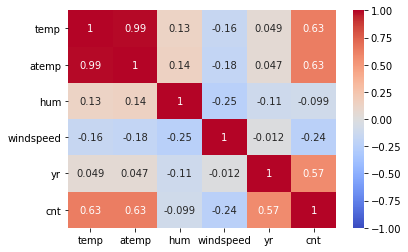

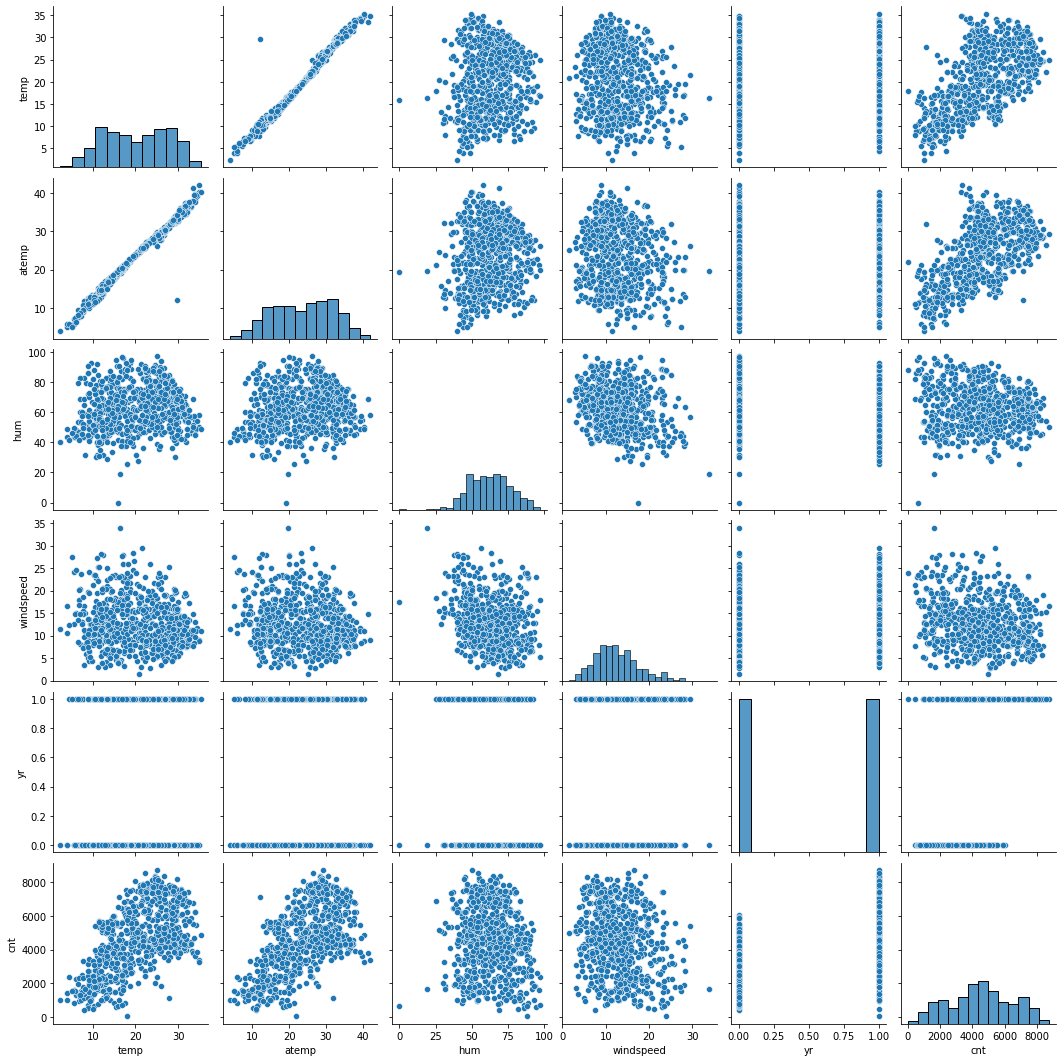

In [9]:
# Continous variable correlation for bi-variate analysis
sns.heatmap(data[cont_cols + ['cnt']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center= 0)
sns.pairplot(data[cont_cols + ['cnt']])
plt.show()

#### Inference - temp and atemp are highly correlated to each other as well as target variable, yet we will leave it for RFE or VIF to remove multicolinearlity during variable reduction process. Also, there is a clear positive pattern between target variable and temp, atemp.Therefore, satisfying one of the assumptions for linear regression

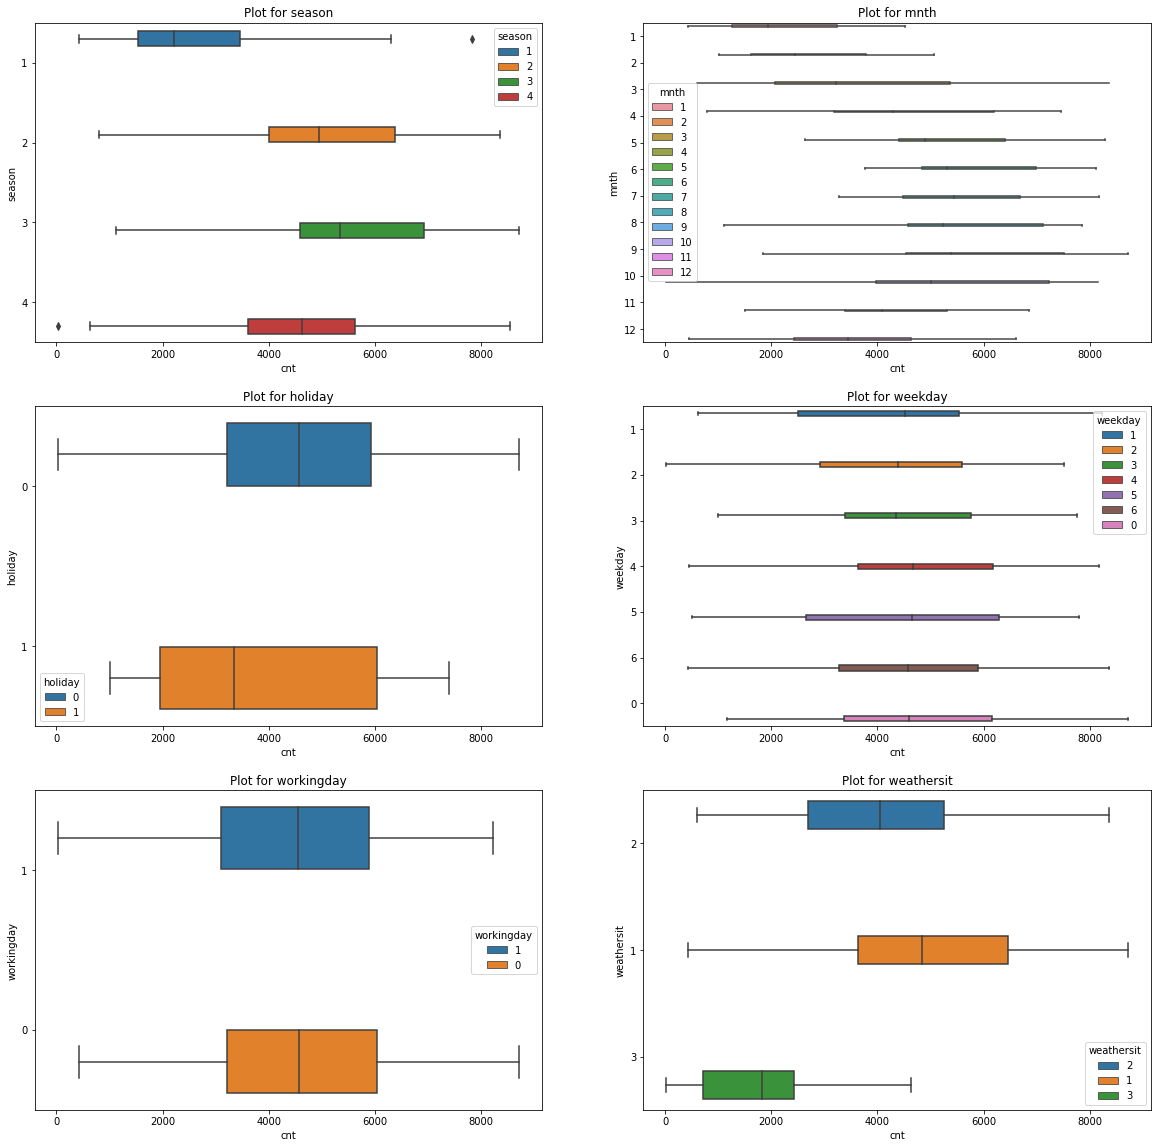

In [10]:
# Analysis for categorical variables with respect to target variable
n_rows = int(len(cat_cols)//2)
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))

for idx, var in enumerate(cat_cols):
    sns.boxplot(data=data, hue=var, x="cnt", y=var, ax=axes[int(idx)//2, int(idx)%2])
    axes[int(idx)//2, int(idx)%2].set_title("Plot for {}".format(var))

plt.show()

#### Inference - Most of the categorical variables except "working day" show variation with target variable, this is a good indication.

In [11]:
# remove original categotrical variables from data now
for var in cat_cols:
    _ = data.pop(var)

## 2. Train-Test split for data

In [12]:
y = data.cnt
_ = data.pop('cnt')
X = data

all_cols = data.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47) # set random_state to a fix value for repeatable results
print("Train data shape = {}, Test data shape = {}".format(X_train.shape, X_test.shape))

Train data shape = (511, 29), Test data shape = (219, 29)


## 3. Scaling for Train and Test data

In [13]:
scaler = MinMaxScaler() # using min-max scalar on independent variables

X_train[all_cols] = scaler.fit_transform(X_train[all_cols]) # fit and transform for train data
X_test[all_cols] = scaler.transform(X_test[all_cols]) # transform for test data

## 4. Selection for Important variables

#### Step 1- Automated variable selection - use RFE and reduce to top 15 variables

In [14]:
select_features = 15 # reducing variables to 15 most important based on automated technique

lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, select_features)
rfe_model = rfe.fit(X_train, y_train)

#take top selected features from RFE results
train_cols = [var[0] for var in zip(all_cols, rfe_model.ranking_) if var[1] == 1]
X_train = X_train[train_cols]
print("List of 15 variables from RFE: ")
list(X_train.columns)

List of 15 variables from RFE: 


['yr',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'season_2',
 'season_3',
 'season_4',
 'mnth_10',
 'mnth_3',
 'mnth_4',
 'mnth_5',
 'mnth_9',
 'holiday_1',
 'weathersit_3']

#### Step 2- Manual Inspection of remaining variables - Based on P-value and VIF

In [15]:
# create a function to get variable VIF and P-value in order to view variable importance and multicolinerlity together
# We will be able to call this function again and again to do manual inspection after each variable removal

def getVIF(df):
    return list(zip(df.columns, [sv.variance_inflation_factor(df.values, i) for i in range(len(df.columns))]))

def getPValue(X, y):
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    res = model.fit()
    print(res.summary())
    _ = X.pop('const')
    pv = [res.pvalues.loc[x] for x in X.columns]
    return list(zip(X.columns, pv))

def getPvalueAndVIF(X, y):
    vif = getVIF(X)
    pvalues = getPValue(X, y)
    
    result = []
    for item in vif:
        var = item[0]
        vif_value = item[1]
        p_value = [x[1] for x in pvalues if x[0] == var][0]
        result.append([var, vif_value, p_value])
            
    return pd.DataFrame(result, columns = ["variable", "vif", "pvalue"]).round(3)


In [16]:
# Inspect the dataframe with 15 variables from RFE result
getPvalueAndVIF(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     167.4
Date:                Tue, 06 Jul 2021   Prob (F-statistic):          8.22e-183
Time:                        17:49:46   Log-Likelihood:                -4131.7
No. Observations:                 511   AIC:                             8295.
Df Residuals:                     495   BIC:                             8363.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2015.2088    197.637     10.197   

,variable,vif,pvalue
0,yr,2.034,0.000
1,temp,374.107,0.001
2,atemp,348.077,0.715
3,hum,8.417,0.000
4,windspeed,4.275,0.000
5,season_2,5.988,0.000
6,season_3,7.162,0.000
7,season_4,2.784,0.000
8,mnth_10,1.598,0.006
9,mnth_3,1.380,0.004


#### Variable "atemp" has high VIF and pvalue > 0.05, so it becomes the first candidate to be removed. Model looks good to start with R square value of 0.835

In [17]:
_ = X_train.pop("atemp") # remve the variable

In [18]:
# Verify data again after variable removal
getPvalueAndVIF(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     179.7
Date:                Tue, 06 Jul 2021   Prob (F-statistic):          6.43e-184
Time:                        17:49:46   Log-Likelihood:                -4131.8
No. Observations:                 511   AIC:                             8294.
Df Residuals:                     496   BIC:                             8357.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2021.1637    196.794     10.270   

,variable,vif,pvalue
0,yr,2.034,0.000
1,temp,22.094,0.000
2,hum,8.308,0.000
3,windspeed,4.175,0.000
4,season_2,5.979,0.000
5,season_3,7.075,0.000
6,season_4,2.771,0.000
7,mnth_10,1.598,0.006
8,mnth_3,1.377,0.004
9,mnth_4,2.347,0.519


#### Model's Adjusted R square increased afer removing variable "atemp". This is a good sign, Reducing variable did not impact the model fit but multicolinearlity is reduced.
#### Next variable to remove - "mnth_4" as it's p-value > 0.05

In [19]:
_ = X_train.pop("mnth_4")

In [20]:
# Verify data again after variable removal
getPvalueAndVIF(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     193.7
Date:                Tue, 06 Jul 2021   Prob (F-statistic):          5.57e-185
Time:                        17:49:46   Log-Likelihood:                -4132.0
No. Observations:                 511   AIC:                             8292.
Df Residuals:                     497   BIC:                             8351.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2027.9809    196.395     10.326   

,variable,vif,pvalue
0,yr,2.025,0.000
1,temp,21.229,0.000
2,hum,8.166,0.000
3,windspeed,4.095,0.000
4,season_2,3.647,0.000
5,season_3,6.970,0.000
6,season_4,2.771,0.000
7,mnth_10,1.595,0.006
8,mnth_3,1.283,0.005
9,mnth_5,1.603,0.109


#### Variable "mnth_4" is removed but it ha no impact on R Square and Adj. R square for the model, this means the variable was not explaining the variance in target valriable at all. Good to remove.
#### Next best candidate for removal is "mnth_5" as it has p-value > 0.05

In [21]:
_ = X_train.pop('mnth_5')

In [22]:
# Verify data again after variable removal
getPvalueAndVIF(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     209.0
Date:                Tue, 06 Jul 2021   Prob (F-statistic):          1.36e-185
Time:                        17:49:46   Log-Likelihood:                -4133.3
No. Observations:                 511   AIC:                             8293.
Df Residuals:                     498   BIC:                             8348.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1987.1361    195.053     10.188   

,variable,vif,pvalue
0,yr,2.025,0.000
1,temp,20.719,0.000
2,hum,8.106,0.000
3,windspeed,4.002,0.000
4,season_2,3.460,0.000
5,season_3,6.742,0.001
6,season_4,2.719,0.000
7,mnth_10,1.592,0.008
8,mnth_3,1.244,0.010
9,mnth_9,1.241,0.000


#### Almost no impact on model R square and Adj. R square values after removing variable "mnth_5", Good to remove.
#### Next candidate variable to remove is "temp" due to very high VIF, but given the nature of problem statement Temperature seems to be an important variable because
1. It is very low p-value i.e.~ 0
2. VIF may show high because temp can be highly correlated with seasons/months
3. Impact of removing the variable on Adj. R square value is very large and no significant improvement seen in R square vs Adj R square

In [23]:
# See what will happens if we remove the "temp" variable

X_train_copy = X_train.copy()
_ = X_train_copy.pop('temp')
getPvalueAndVIF(X_train_copy, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     142.2
Date:                Tue, 06 Jul 2021   Prob (F-statistic):          5.68e-146
Time:                        17:49:46   Log-Likelihood:                -4230.0
No. Observations:                 511   AIC:                             8484.
Df Residuals:                     499   BIC:                             8535.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2969.9108    222.004     13.378   

,variable,vif,pvalue
0,yr,1.955,0.000
1,hum,5.741,0.000
2,windspeed,3.731,0.000
3,season_2,1.905,0.000
4,season_3,2.107,0.000
5,season_4,2.435,0.000
6,mnth_10,1.525,0.000
7,mnth_3,1.232,0.005
8,mnth_9,1.231,0.000
9,holiday_1,1.037,0.000


#### Interesting to notice that the R square value went down by a large margin from 0.83 to 0.76 when variable "temp" is removed. Therefore we will keep this variable

#### Next variable to inspect is "hum" whose VIF is in 5-10 range. We would inspect and see the impact of removing the variable on the model

In [24]:
# Check what will happen if we remove the "hum" variable

X_train_copy = X_train.copy()
_ = X_train_copy.pop('hum')
getPvalueAndVIF(X_train_copy, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     192.2
Date:                Tue, 06 Jul 2021   Prob (F-statistic):          1.92e-171
Time:                        17:49:46   Log-Likelihood:                -4169.6
No. Observations:                 511   AIC:                             8363.
Df Residuals:                     499   BIC:                             8414.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          904.3086    161.344      5.605   

,variable,vif,pvalue
0,yr,2.025,0.000
1,temp,14.674,0.000
2,windspeed,3.766,0.000
3,season_2,3.428,0.000
4,season_3,6.395,0.000
5,season_4,2.625,0.000
6,mnth_10,1.587,0.066
7,mnth_3,1.232,0.015
8,mnth_9,1.219,0.001
9,holiday_1,1.033,0.000


#### Notice that the R square value went down from 0.83 to 0.81 when variable "hum" is removed. Therefore we will keep this variable.

#### Let us now inspect variable "season_3" with VIF in range 5-10

In [25]:
_ = X_train.pop('season_3')
getPvalueAndVIF(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     222.2
Date:                Tue, 06 Jul 2021   Prob (F-statistic):          2.66e-184
Time:                        17:49:46   Log-Likelihood:                -4139.2
No. Observations:                 511   AIC:                             8302.
Df Residuals:                     499   BIC:                             8353.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1937.1759    196.548      9.856   

,variable,vif,pvalue
0,yr,2.010,0.000
1,temp,6.474,0.000
2,hum,7.688,0.000
3,windspeed,3.883,0.000
4,season_2,1.564,0.000
5,season_4,2.033,0.000
6,mnth_10,1.543,0.041
7,mnth_3,1.184,0.057
8,mnth_9,1.190,0.000
9,holiday_1,1.037,0.000


#### Removing variable "season_3" seems to be good because
1. It did not impact R square value a lot
2. Variables "temp" and "hum" are in controlled limits for VIF value i.e. < 10 after removing "season_3", this means that the multicolinearity was because of variable "season_3" with "temp" and "hum", which seems to be logical, seasons are correlated to temperature and humidity.

#### Next variable to remove is "mnth_3", since its p-vaue increased over 0.05 after removal of last variable

In [26]:
_ = X_train.pop('mnth_3')
getPvalueAndVIF(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     242.8
Date:                Tue, 06 Jul 2021   Prob (F-statistic):          1.01e-184
Time:                        17:49:46   Log-Likelihood:                -4141.0
No. Observations:                 511   AIC:                             8304.
Df Residuals:                     500   BIC:                             8351.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1990.6743    195.052     10.206   

,variable,vif,pvalue
0,yr,2.001,0.000
1,temp,6.321,0.000
2,hum,7.502,0.000
3,windspeed,3.753,0.000
4,season_2,1.564,0.000
5,season_4,1.987,0.000
6,mnth_10,1.543,0.036
7,mnth_9,1.186,0.000
8,holiday_1,1.035,0.000
9,weathersit_3,1.112,0.000


### Finally - Good to see that there all remaining 10 variables are with p-value <= 0.05  and VIF < 10. 

In [27]:
final_vars = list(X_train.columns)
print("Final list of variables = {}".format(final_vars))

Final list of variables = ['yr', 'temp', 'hum', 'windspeed', 'season_2', 'season_4', 'mnth_10', 'mnth_9', 'holiday_1', 'weathersit_3']


## 5. Model Building

In [28]:
# check for final model statistics with final list of variables
X_train = sm.add_constant(X_train)
sm_model = sm.OLS(y_train, X_train)
res = sm_model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     242.8
Date:                Tue, 06 Jul 2021   Prob (F-statistic):          1.01e-184
Time:                        17:49:46   Log-Likelihood:                -4141.0
No. Observations:                 511   AIC:                             8304.
Df Residuals:                     500   BIC:                             8351.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1990.6743    195.052     10.206      0.000    1607.452    2373.897
yr            2024.1545     72.500     27.919      0.000    1881.712    2166.597
temp          5098.6614    170.310     29.938      0.000    4764.050    5433.273
hum          -2039.5256    225.019     -9.064      0.000   -2481.624   -1597.427
windspeed    -1724.4188    237.129     -7.272      0.000   -2190.312   -1258.526
season_2       718.0154     89.421      8.030      0.000     542.328     893.702
season_4      1042.6815    109.223      9.546      0.000     828.089    1257.274
mnth_10        343.1706    163.593      2.098      0.036      21.756     664.585
mnth_9         865.5342    152.500      5.676      0.000     565.915    1165.154
holiday_1     -934.0761    212.949     -4.386      0.000   -1352.461    -515.691
weathersit_3 -1504.6142    252.033     -5.970      0.000   -1999.788   -1009.441
==============================================================================
Omnibus:                       84.010   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.873
Skew:                          -0.890   Prob(JB):                     8.73e-40
Kurtosis:                       5.297   Cond. No.                         13.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Inference - Model looks good
1. R-square and Adjusted R-square values are very close i.e. minimum penalty due to multicolinearity
2. All p-values <= 0.05 i.e. independent variable are able to explain the variance in target variable
3. High F-statistic value i.e. Model is a good fit, all variables combined explains


the variance in target variable

## 6. Model Evaluation

In [29]:
# Check the trained model results on test data
X_test = X_test[final_vars]
X_test = sm.add_constant(X_test)

y_train_pred = res.predict(X_train) 
y_test_pred = res.predict(X_test)

print("Train data R-square = {}".format(round(r2_score(y_train, y_train_pred), 2)))
print("Test data R-square = {}".format(round(r2_score(y_test, y_test_pred), 2)))

Train data R-square = 0.83
Test data R-square = 0.81


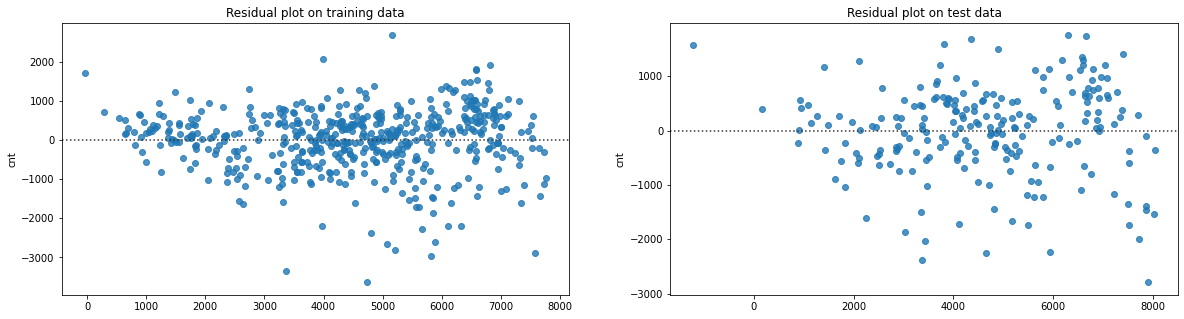

In [30]:
figure, axes = plt.subplots(1, 2, figsize=(20,5))
sns.residplot(y_train_pred, y_train, ax = axes[0])
axes[0].title.set_text("Residual plot on training data")

sns.residplot(y_test_pred, y_test, ax = axes[1])
axes[1].title.set_text("Residual plot on test data")

plt.show()

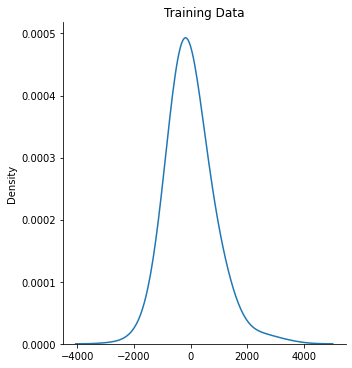

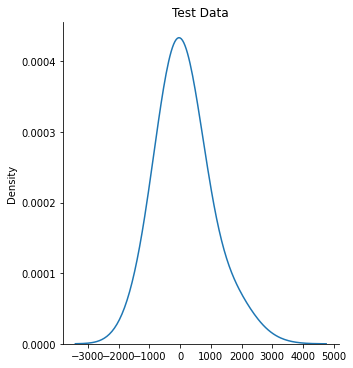

In [31]:
#check normal distribution for error terms
sns.displot((y_train_pred-y_train), kind="kde", bw_adjust=2)
plt.title("Training Data")
sns.displot((y_test_pred-y_test), kind="kde", bw_adjust=2)
plt.title("Test Data")
plt.show()

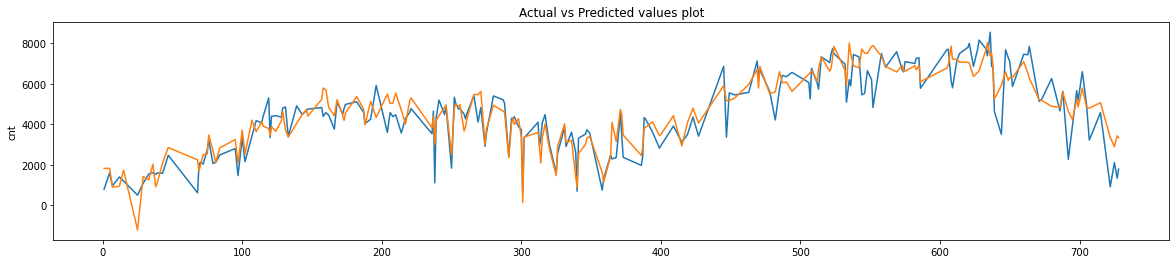

In [32]:
# plotting actual vs predicted
plt.figure(figsize=(20, 4))
plt.title("Actual vs Predicted values plot")
sns.lineplot(data=y_test)
sns.lineplot(data=y_test_pred)
plt.show()

<AxesSubplot:>

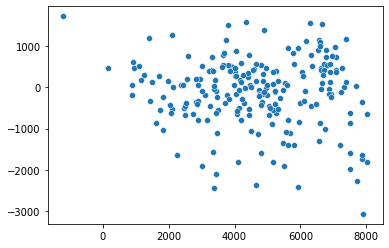

In [33]:
# plotting error term and predicted value to check independence of error term
sns.scatterplot(x=y_test_pred, y= (y_test - y_test_pred))

### Final Comments
Assumptions for Linear Regression are successfully met - 
1. Linearity - Atleast one variable shows a linear relationship to target variable during EDA - Yes, we saw variable temp has a positive relationship
2. Error terms are normally distributed - Yes, visible through the residual plots
3. Homoscedasticity - Yes, Error term seems to have almost constant variance as seen in the residual plot.
4. Error terms are independent - Yes, Can be verified from plot of error vs predicted.

Overall Model description -
1. Model trained with R square value of 0.83
2. Adj R-square value very near to R-square indicates model is free from multicolinearlity
3. All variables used with P-value <= 0.05
4. High F-statistics show good model fit and stability based on all features